# Summary of practical_session_1

Note: We use the [CopelliaSim](https://www.coppeliarobotics.com/) robotic simulator, which was formerly called V-REP. In the text below we use both names interchangeably.


Open the scene called `epuck-scene-1.ttt` in the directory `pyvrep-epuck/vrep_scenes` (in V-REP: `File -> Open scene`). This will load a scene containing a simulated version of an [E-puck](http://www.e-puck.org/) mobile robot in an area bounded by four walls (there are also other elements around but we don't care about them in this session). This robot has a number of actuators and sensors that we will describe soon (for example, the long red lines indicate the field of view of the robot through two proximeter sensors it is equipped with). You can use the scene rotation, translation and zooming buttons to inspect the robot in more detail. However it is not recommended to save the modified scene, since the scene view has been chosen to be convenient for the exercises below. To reload the scene as it was before, use `File -> Open recent scene -> epuck-scene-1.ttt` (choosing `no` in case one asks you to save the previous one). 

Let's connect this Jupyter Notebook document to the simulator which is running on your machine. The command below imports the library written for this purpose and creates two objects: a `simulator` object and an `epuck` object. As for the previous cell, click on the code below and press `Shift + Enter` to execute it. In the following, we will not repeat this last sentence, just execute the code in each cell which contains some code (unless not to do it is explicitly specified).

In [1]:
from simulator_interface import open_session, close_session
simulator, epuck = open_session()

Once the cell above has been executed (it can take a few seconds), you will observe that the simulator has been started in the V-REP interface, as indicated by the "play-like" button which is pressed in the top menu bar of V-REP. Note that you should never press the play/pause/stop buttons in the simulator, use pyhon commands in the notebook instead.

It can be the case that at one point during the session, the connection is lost and consequently you can't control the robot anymore. If you experience this problem, follow the steps below.

First, close the current session:

In [2]:
close_session(simulator)

Then restart this notebook by selecting `Kernel -> Restart` in the menu bar, and re-open the session by executing:

In [1]:
from simulator_interface import open_session, close_session
simulator, epuck = open_session()

## Actuators

The E-Puck robot has two wheels, allowing its navigation in the environment. Each wheel speed can be controlled individually. Let's for example set the speed of the left wheel to 1 (in radian per second):

In [2]:
epuck.right_spd = 1

The code line above means *set the velocity of the left wheel to 1 rad/s*. You should see the robot moving in a circle around itself, since the left wheel turns and the right one doesn't. Similarly, you can of course set the speed of the right wheel by using `epuck.right_spd` instead of `epuck.left_spd`. Try it by modifying the cell above. To stop the robot, you have to set both wheel speeds to `0`:

In [3]:
epuck.left_spd = 0
epuck.right_spd = 0

A shortcut for the cell above is:

In [ ]:
epuck.stop()

Let's try more complex choreographies. A useful function for this is the ability to wait for a given time by using `epuck.wait(x)`, where `x` has to be replaced by the time to wait for, in seconds. Here is an example, where the robot goes forward during 3 seconds, then turns right during 0.5 second, then goes forward again during 2 seconds, and finally stops.

In [6]:
# Move forward, by setting each wheel speed at the same positive value
epuck.left_spd = 3
epuck.right_spd = 3

# Wait for 3 seconds, keeping moving forward at the same speed
epuck.wait(3)

# Turn right by setting a positive speed to the left wheel and stoping the right one (null speed)
epuck.left_spd = 3
epuck.right_spd = 0

# Keep turning for 0.5 second
epuck.wait(0.5)

# Move forward again for 2 seconds
epuck.left_spd = 3
epuck.right_spd = 3
epuck.wait(2)

# Stop the robot
epuck.left_spd = 0
epuck.right_spd = 0

## Sensors

We use a modified version of the E-Puck robot, where we only use the two front sensors. Their maximum detection distance is 2 meters. The angle of view of each proximeter is approximately 90°. The field of view of the proximeters is indicated by the red lines in the V-REP interface (90 degrees for each proximeter).

Whenever a proximeter detects an obstacle, a blinking line is displayed in V-REP showing the corresponding direction. Note that each proximeter detects only the closest object within its own field of view (indicate by the red lines). The current activation of the two front proximeters can be accessed with:

In [7]:
epuck.prox_activations()

array([0.57508011, 0.39042119])

This command returns a Numpy `array`. Here we see two values: the first one corresponds to the activity of the left proximeter, the second to the activity of the right one. Those values do NOT correspond to distances, but are instead activation values bounded between 0 and 1, where 0 indicates that no obstacle is perceived (i.e. the proximeter doesn't detect any object withing its field of view), and 1 indicates that an object is in contact with the proximeter. In other word, the higher the activation, the closer the object (inversely proportional to the object distance). 

Make sure that you are able to identify which sensor corresponds to which value (i.e. map the values above to the blinking lines in V-REP). 

You can store the values returned by `epuck.prox_activations()` in two distinct variables, which will facilitate using them for further computation. If you execute the following command:

In [8]:
left, right = epuck.prox_activations()

Then the variables `left` and `right` will contain the activations of the left and right proximeters, respectively. You can check their values using the `print` instruction:

In [11]:
print(left)

0.5787385117006487


In [12]:
print(right)

0.390162885064143


**However**, the values in `left` and `right` will not be updated if the proximeter activations change over time. To experience it, move the robot in a different location in the scene where the proximeter activations should be different, and re-execute the `print` commands above. You will observe that the returned values are the same as before, whereas the proximeter activities should be different. In order to refresh the values in the `left` and `right` variables, you need to re-execute the command `left, right = epuck.prox_activations()`:

In [13]:
left, right = epuck.prox_activations()
print(left, right)

0.8447268925890007 0.5479889134780834


## Naive behavior implementation using a For loop

The code below implement a behavior that connects sensors to motors, so that the robot goes forward at a speed that depends on the summed activity of both proximity sensors. The closer the robot is from an obstacle, the slower it moves (but always going forward, without rotation). Remember that proximeter values have to be refreshed explicitely each time we need to observe them by calling `left, right = epuck.prox_activations()` To do so, we use a `for` loop.

In [14]:
# Repeat 1000 times the indented code:
for i in range(100):
    # Read the proximeter values and store them in the "left" and "right" variables
    left, right = epuck.prox_activations()
    
    # Compute the sum of the values returned by the left and right proximeters.
    # This sum will be between 0 and 2 because both "left" and "right" are between 0 and 1
    sum_of_proxs = left + right
    
    # Compute the activation that will be applied to both wheels. 
    # The closer the obstacle (i.e. the higher the value returned by the proximeters), the lower the wheel activation should be.
    # Note that wheel activation is bounded between 0 and 1
    wheel_activation = 1.0 - sum_of_proxs / 2.0
    
    # Set the activation of both wheels to the value we just have computed
    epuck.left_wheel = wheel_activation
    epuck.right_wheel = wheel_activation
    
    # Waits for 100 milliseconds before starting the next iteration (to avoid overloading you computer)
    epuck.wait(0.1)

In [15]:
epuck.stop()

You can now close this session properly by executing the cell below, and continue with the next session

In [2]:
close_session(simulator)

# Summary of practical_session_2

Close the previously opened scene (`epuck-scene-1.ttt`) and open `epuck-scene-2.ttt`

In [10]:
from simulator_interface import open_session, close_session
simulator, epuck = open_session()

## Using normalized speed values in actuators

Above we used `epuck.left_spd` and `epuck.right_spd` to set the wheel speeds. We will now be using `epuck.left_wheel` and `epuck.right_wheel` instead. The difference is the following:
- When using `epuck.left_spd` and `epuck.right_spd` as in the previous practical session, the values are in radian per second (rad/s). This means that when one executes `epuck.left_speed = 2`, the speed of the left wheel is set to 2 rad/s (corresponding approximately to a complete wheel rotation every 1.5 seconds, since a complete rotation (360º) corresponds to `pi=3.14...` radians.
- When using `epuck.left_wheel` and `epuck.right_wheel` as above, the values are normalized. This means that `epuck.left_wheel` expects a value between 0 and 1, where 0 corresponds to no rotation (null speed), and 1 corresponds to the maximum allowed speed (set to 20 rad/s). You can change the maximum speed with:

In [17]:
epuck.max_speed = 10.
# Now the maximum speed is 10 rad/s. 
# This means that when executing epuck.left_wheel = 1, the left wheel will rotate at the speed of 10 rad/s

Let's actually keep the maximum speed at 10 rad/s for this session.

## Practical definition of a behavior

The example behavior defined above illustrates the general structure of a behavior. 

**Definition:** a behavior consists of a loop repeated at a certain frequency where (1) the values of relevant sensors are read, (2) some computation is performed using these values and (3) commands are sent to the robot motors according to the result of this computation.

In the example above, the frequency of the behavior is approximately 10 Hz, i.e. the core of the loop is executed approximately 10 times per second (because we wait for 0.1s at the end of each iteration). This is an approximation because we don't take into account the time needed to execute the instructions occurring before the waiting period. Step (1) corresponds to the reading of the left and right proximeter activations. Step (2) corresponds to the computation of `wheel_activation` according to the sum of the proximeter activations. Finally, Step (3) corresponds to setting the speed of both wheels to the value of `wheel_activation`.

Note that the code above will take a while to be executed (approximately `1000 * 0.1 = 100` seconds, since the loop is repeated 1000 times). During this time, you can't execute anything else in this notebook. To stop the execution before it terminates by itself, you have to press the "stop-like" button in the top menu bar of this document. 

This approach has three major drawbacks:
- Only one behavior can run at a time.
- The behavior has a fixed duration (at one point it will stop)
- We can't stop a behavior programmatically (instead we have to press the "stop-like" button).

To overcome these problems, we provide a more flexible method for defining and executing behaviors. Let's rewrite the behavior above using that method. First make sure the previous code is not still being executed by pressing the "stop-like" button in the top menu bar of this document. Now, defining a behavior boils down to defining a function which includes the core of the behavioral loop:

In [18]:
# The code in this cell defines a function called slow_down (first line),
# which takes as argument the epuck (first line, in parenthesis),
# and returns the left and right speed activation to be applied to the motors (last line)

def slow_down(epuck):
    # Step (1): read the sensor values
    left, right = epuck.prox_activations()
    
    # Step (2): do some computation
    sum_of_proxs = left + right
    wheel_activation = 1.0 - sum_of_proxs / 2.0
    
    # Step (3): return the motor activations
    return wheel_activation, wheel_activation

The cell above defines a function called `slow_down`. In computer programming, a function is a sequence of instructions that perform a specific task depending on some parameters (called the arguments of the function) and that returns a result. In this sense it is very similar to the mathematical definition of a function, as for example when we write `y = f(x)`, where `f` is the name of the function, `x` is its argument, and `y` is the result.

As seen above, the definition of a function in Python starts with the keyword `def`, followed by the arbitrary name we choose for the function (here we called it `slow_down` to reflect the purpose of the behavior defined in it). Then come the arguments of the function in parenthesis (in our case it will be the variable representing the robot, called `epuck`) and finally the symbol `:`. Below the first line, you find the instructions that this function will execute when it will be called. Those instructions need to be intended right with respect to the first line. In this example, the instructions are the exact same as in the core of the previous `for` loop, except that:
- we omit the last line `epuck.wait(0.1)` (the frequency at which the behavior will be executed will be set in more rigorous way below),
- we don't directly set the motor activations using `epuck.left_wheel` and `epuck.right_wheel`. Instead, we *return* the values of the motor activations in the last line and they will be automatically sent to the robot motors when the behavior will be executed. In the last line, the values after the `return` keyword have to be the left and right speed activation (in this order). Both activations have to be between 0 and 1. (In the `slow_down` behavior above, both activations are the same since we don't want the robot to turn).

Note that a function definition, as the one above, does not execute the instructions contained in it, it only defines them so that they can be executed later when the function will be *called*. In our case, we will not explicitly call the function, instead it will be done behind the scene when we will start the behavior on the robot (see below).

Once the behavior is defined as a function, we can attach it to the robot by executing:


In [19]:
epuck.attach_behavior(slow_down, freq=10)

The line above means: attach the behavior defined in the function `slow_down` to the `epuck` robot and set the frequency at which it will be repeated to 10Hz. Note that this instruction does not execute the behavior on the robot, it only informs the robot that the behavior is available to it. 

In order to actually start the behavior, we have to execute:

In [20]:
epuck.start_behavior(slow_down)

Behavior slow_down started


You should now see the robot executing the exact same behavior as before (if the robot is already close to an obstacle, move it to a more open space to observe it slowing down).

The line above means: start running the previously attached `slow_down` behavior on the `epuck`. Executing the above line will basically do the same thing as executing the `for` loop at the start of this document. Here, the function `slow_down` will be executed at a frequency of 10Hz as set in the previous cell (i.e. 10 times per second), indefinitely. 

Using this method has the following advantages over the previous method using the `for` loop:
- It is more compact to write and it will allow to better structure your code when you will have to deal with multiple behaviors and multiple robots.
- It better manages the frequency at which the behavior is run. Now the behavior runs at exactly 10Hz, whereas in the previous method we could only approximate the true frequency.
- It is not blocking as the previous method was. This means that you can still use this notebook while the behavior is running on the robot. For example, let's read the proximeter activations while the robot is still executing the `slow_down` behavior:

In [27]:
epuck.prox_activations()

array([0.73118397, 0.63270367])

Each time you execute the cell above, you should see the proximeter activation changing because the robot is moving. However, you should avoid setting motor values while a behavior is running since this could conflict with the behavior also setting those values. When a behavior is started, it runs indefinitely until you explicitly tell it to stop. To do so, you have to execute:

In [28]:
epuck.stop_behavior(slow_down)

Behavior slow_down stopped


Note that the robot will continue moving using the last wheel speeds that were set by the behavior. You can set both wheel speeds to 0 by executing:

In [29]:
epuck.stop()

Finally, if you don't want the behavior to be attached to the robot anymore (for example if you want to test another behavior), you can execute:

In [30]:
epuck.detach_behavior(slow_down)

Behavior slow_down detached


At anytime, you can check what behaviors are attached to the robot with:

At anytime, you can check what behaviors are attached to the robot with:

In [31]:
epuck.check_behaviors()

No behavior attached


You can also use this shortcut to detach all behaviors previously attached to a robot:

In [32]:
epuck.detach_all_behaviors()

## Implementing the Braitenberg vehicles

Let's now practice a bit. Remember the Braitenberg Vehicle examples we have seen in [this slide](https://docs.google.com/presentation/d/1s6ibk_ACiJb9CERJ_8L_b4KFu9d04ZG_htUbb_YSYT4/edit#slide=id.g31e1b425a3_0_0). Those vehicles are very similar to the ePuck robot in the simulator. 
- It is equipped with two sensors that are activated according to the proximity of a source. With the ePuck, each proximeter sensor returns a value between 0 and 1 that is inversely proportional to the distance from the closest obstacle it perceives (the closer the obstacle, the highest to proximeter activation).
- It is equipped with two motors allowing the robot to move. With the ePuck, we can set the activation of each wheel independently with a value between 0 and 1 (where 1 means maximum speed). 
- A behavior links sensor activations to motor activations. In the Braitenberg vehicles, this is achieved through connections that are either excitatory (the activity of the sensor increases the activity of the motor it is connected to) or inhibitory (the activity of the sensor decreases the activity of the motor it is connected to). In the ePuck, we have seen above that we can define a behavior as a function that (1) read the sensor activities (2) perform some computation and (3) use the result of that computation to set the wheel speed. 

Therefore, we can implement in the ePuck the various types of vehicle behaviors shown in the slide, where defining excitatory and inhibitory connections will be done through Step (2) above (*perform some computation*). We have actually already done it with the `slow_down` behavior we have defined above.  

In [11]:
def fear(epuck):
    left, right = epuck.prox_activations()
    return left, right

That's pretty easy, isn't it? As illustrated in the slide, the `fear` behavior simply consists in the left sensor exciting the left wheel, and the right sensor exciting the right wheel. Therefore, the simplest way of programming this behavior is to directly map the left and right sensor activations to the left and right wheel speed, respectively. This is what is done in the function definition just above.

Let's now analyze the properties of this `fear` behavior in more detail. Place the E-Puck in an open area in the V-REP scene, attach and start the `fear` behavior by executing the cell below, and observe how the robot behaves.

In [3]:
epuck.detach_all_behaviors()  # Just in case a behavior is still attached

epuck.attach_behavior(fear, freq=10)
epuck.start_all_behaviors()

Behavior fear started


1. What happens when the activity of both sensors is null? (i.e. no obstacle is detected.) Why?
2. How does the robot react when it detects an obstacle? (e.g. a pillar.) Why?
3. How does the robot reacts when it approaches a corner?  Why?
4. How does the robot reacts when it approaches perpendicularly to a wall?  Why?
4. Imagine a small animal equipped with such a behavior in the wild. What would be its evolutionary advantages and drawbacks? (could it escape from a predator? could it collect food? Could it hide itself?)

Program the `aggression` behavior illustrated in [the slide](https://docs.google.com/presentation/d/1s6ibk_ACiJb9CERJ_8L_b4KFu9d04ZG_htUbb_YSYT4/edit#slide=id.g31e1b425a3_0_0), which consists of crossed excitatory connections. 

In [7]:
def aggression(epuck):
    sl, sr = epuck.prox_activations()
    ml = 1. - sr
    mr = 1. - sl 
    return ml, mr

In [13]:
epuck.detach_all_behaviors()  # Just in case a behavior is still attached

epuck.attach_behavior(aggression, freq=10)
epuck.start_all_behaviors()

Behavior obstacle_avoidance started


In [16]:
epuck.max_speed = 5

Before executing the behavior you have defined in the cell just above, first detach the previous one and immobilize the epuck:

In [14]:
epuck.detach_all_behaviors()
epuck.stop()

Then attach the `aggression` behavior and start it:

In [17]:
epuck.attach_behavior(aggression, freq=10)
epuck.start_all_behaviors()

Behavior aggression started


You can now close this session properly by executing the cell below, and continue with the next session

In [ ]:
close_session(simulator)

# Summary of practical_session_3

Close the previously opened scene (`epuck-scene-2.ttt`) and open `epuck-scene-3.ttt`

In [1]:
from simulator_interface import open_session, close_session
simulator, epuck = open_session()

## Selectively detecting scene objects

To define a repertoire of interesting behaviors, we need the robot to selectively sense the proximity of different types of objects. For example, we might want to define a behavior for obstacle avoidance and another one for attraction towards mates. The first behavior will require the proximity from walls and pillars, whereas the second will require the proximity from other robots (although there is only one robot in the scene for now, we'll add more at the end of this session). 

We can filter the result returned by the E-Puck's proximeters by providing the argument `tracked_objects` to the `prox_activations` function:

In [5]:
left, right = epuck.prox_activations(tracked_objects=["Cup"])
print(left, right)

0.0 0.7411325505954987


Executing the cell above will return the proximeter activations only for the `Cup` objects (the kind of trash bins in the V-REP scene). Give it a try by moving a cup in the detection area of the proximiters and re-executing the cell above to observe the change in the returned values. You can also check that the proximeter activations are not modified by other objects such as pillars.

The `tracked_objects` argument requires a list of strings (`["Cup"]` in the example above). In Python, a list is a collection of values separated by commas and surrounded by square bracket: `["Cup"]` is therefore a list of only one element (the string `"Cup"`), whereas `["Cup", "ePuck"]` is a list of two elements (the strings `"Cup"` and `"ePuck"`). 
The `tracked_objects` argument, as its name indicates, sets the objects to be tracked by the proximeters. Each object in a V-REP scene has a name, which is shown when you select an object by clicking on it in the interface. You can also inspect the names of all the objects in the `Scene hierarchy` panel on the left (if not visible, you can activate in the `Tools` menu). For example, we see that the cups have the names `Cup`, `Cup0`, `Cup1` etc ..

In the cell above, `tracked_objects=["Cup"]` means *only return the proximeter activations of objects having their names starting with `"Cup"`*. Since only cups have their names starting with `Cup`, it will return the proximeter activation only for cups, not considering e.g. walls and pillars.

In order to track several types of objects at the same time, we can pass several strings to `tracked_objects`. For example, if we want to track both cups and trees, we will write:

In [6]:
left, right = epuck.prox_activations(tracked_objects=["Cup", "Tree"])
print(left, right)

0.0 0.7444829427164087


This is because all trees in the scene have their name starting with `Tree` (`Tree`, `Tree#0`, `Tree#1` etc..., as shown in the `Scene hierarchy` panel).

Let's define an `obstacle_avoidance` behavior. Obstacles are walls, pillars and trees, but not cups.  The robot has to turn in the direction opposite to the obstacle, with its speed inversely proportional to the proximeter activations (the closer an obstacle, the lower the speed). 
*Tip:* it is similar to the `shyness` behavior of [Braitenberg vehicles](https://docs.google.com/presentation/d/1s6ibk_ACiJb9CERJ_8L_b4KFu9d04ZG_htUbb_YSYT4/edit#slide=id.g31e1b425a3_0_0).

In [2]:
def obstacle_avoidance(epuck):
    # Write your code below
    left, right = epuck.prox_activations(tracked_objects=['20cm', 'Tree'])
    return 1. - right, 1.- left

Remember that to test a behavior, you first have to detach all behaviors that could still be attached to the E-Puck, then to attach and start the new one, that is:

In [9]:
epuck.detach_all_behaviors()
epuck.attach_behavior(obstacle_avoidance, freq=10)
epuck.start_all_behaviors()

Behavior obstacle_avoidance started


In [12]:
epuck.stop()

## Environmental dynamics

Until now the environment in which the E-Puck is evolving is quite static: although some objects can be pushed by the robot (e.g. the cups), there is nothing that appears or disappears in the environment. We are now going to see how we can generate food sources appearing at random positions in the environment and disappearing whenever a robot eat them. A food source is modeled as a V-REP `Sphere` object, meaning that it can roll on the floor. Making such spheres to appear at regular time intervals and at random positions in the environment is done with:

In [3]:
simulator.start_sphere_apparition(period=10.)

Routine sphere_apparition started
Routine eating started


where `period` indicates the time interval at which spheres will appear (here every 5 seconds). In order to stop sphere apparition:

In [20]:
simulator.stop_sphere_apparition()

Routine sphere_apparition stopped
Routine eating stopped


We can also specify in which area spheres appear through the `min_pos` and `max_pos` arguments:

In [76]:
simulator.start_sphere_apparition(period=10., min_pos=[-2, -1, 1], max_pos=[2., 0.5, 2])

Routine sphere_apparition started
Routine eating started


The cell above will generate spheres at random 3D positions $(x, y, z)$ in the scene with $x\in[-2, 2]$, $y\in[-1, 0.5]$ and $z\in[1, 2]$ (analyze the cell above to understand how the `min_pos` and `max_pos` arguments are converted in $(x, y, z)$ intervals and ask us if it is not clear). You can check how the $x, y, z$ axes are oriented at the bottom-right corner of the V-REP scene (try to rotate the scene while looking at it). When selecting an object, you can check the coordinate of its center in the text located in the top-left corner of the scene (`Last selected object position`). The center of the scene is at $x=0, y=0, z=0$. The floor is contained in (approximately) $x\in[-2.5, 2.5]$ and $y\in[-2.5, 2.5]$, with $z=0$ on the surface. 

Whenever the E-Puck is touching a sphere it will "eat" it, meaning that the sphere will disappear from the environment. You can see it by manually moving the E-Puck close to a sphere (the sphere should disappear, although this might take some time). Note however that the spheres will disappear only if the sphere apparition is activated (i.e. if you haven't executed `simulator.stop_sphere_apparition()` as the last command: in that case, you will have to re-execute `simulator.start_sphere_apparition(period=5.)` as above).

If no E-Puck is eating the spheres, you might end up with a large number of spheres occupying the environment and this could dramatically impair the V-REP performances. In that case, clean the environment by closing and restarting the session as explained at the beginning of the notebook. A good practice to avoid the proliferation of spheres is to increase the period (e.g.`simulator.start_sphere_apparition(period=20.)`) and to stop sphere apparition whenever you don't need it.

## Combining behaviors

Let's define a behavior allowing the robot to catch food sources, let's call it `foraging`. The robot has to orient itself toward food sources, with a speed proportional to the proximiter activations (the closer the food source, the higher the speed) *Tip 1:* It's similar to the `aggression` behavior. *Tip 2:* Generated spheres have their names starting by "Sphere" (you can see it in V-REP in the scene hierarchy panel).

In [4]:
def foraging(epuck):
    # Write your code below
    left, right = epuck.prox_activations(tracked_objects=['Sphere'])
    return right, left

Attach and start the behavior on the E-Puck: 

In [5]:
# First detach previous behaviors that might still be attached to the robot
epuck.detach_all_behaviors()

# Write the code to attach and start the `foraging` behavior below
epuck.attach_behavior(obstacle_avoidance, freq=10.)
epuck.attach_behavior(foraging, freq=10.)

epuck.start_all_behaviors()


Behavior obstacle_avoidance started
Behavior foraging started


Whenever a sphere is detected by the proximeters, the robot should go towards it. However, if at one point the proximeters don't detect any sphere, the robot will probably stop (depending on how you have defined the behavior). The only event that could make the robot move again would be a sphere that rolls within the proximeter detection area, which is not very likely to happen (and therefore quite a bad option if the survival of the robot depends on its foraging abilities). A solution to avoid such a blocking situation is to combine the `foraging` behavior with another one that keeps the robot in movement, as it is for example the case of the `obstacle_avoidance` behavior we have defined before. Let's attach and start the `obstacle_avoidance` behavior, but this time without detaching the previously attached `foraging` behavior:

In [ ]:
epuck.attach_behavior(obstacle_avoidance, freq=10)
epuck.start_behavior(obstacle_avoidance)

Since we haven't detached the previous behavior, the robot is now executing two behaviors in parallel. This can be checked with:

In [80]:
epuck.check_behaviors()

No behavior attached


which tells us that both behaviors are attached and started. In V-REP, you can see that the robot is now both foraging and avoiding obstacles. For doing so, the motor activation sent to each wheel corresponds to the average of the motor activation returned by each behavior (this averaging is implemented internally, you don't need to worry about it).

In [17]:
epuck.has_eaten()

False

In [81]:
epuck.detach_all_behaviors()

## Dealing with multiple robots

This section explains how to deal with multiple robots and how to attach different behaviors to them.

First close the current session:

In [6]:
close_session(simulator)

Then restart the notebook (`Kernel -> Restart`).

Select the E-Puck robot by clicking on it in the scene. Copy-paste it, either using the `Edit` menu, or by pressing the usual editing shortcut `Ctrl-C` then `Ctrl-V`. A new E-puck will be placed in the scene at the exact same position as the previous one. Drag and drop this new robot to another position. Now you should see two robots in the scene.

Re-open a session, this time requesting the references to two E-Pucks instead of one, by executing:

In [83]:
from simulator_interface import open_session, close_session

simulator, epuck1, epuck2 = open_session(n_epucks=2)

Now you have access to the two E-Pucks through the variables `epuck1` and `epuck2` (these variables names are arbitrary, you can choose whatever you want, e.g. `predator` and `prey`). You can attach and start behaviors on each E-Puck independently, in the same way as you did before, simply using either the `epuck1` and `epuck2` variables instead of only `epuck` one as before.

As an example, let's say we want to attach the `obstacle_avoidance` behavior we have defined above to `epuck1`, and both the `obstacle_avoidance` and the `foraging` behaviors to `epuck2`. 
Since we have restarted the notebook, you first need to re-execute the cells defining both behaviors above (i.e. the cells starting with `def obstacle_avoidance(epuck):` and `def foraging(epuck):`).

The code will be:

In [ ]:
# As usual, we detach the possibly already running behaviors.
# Since we now have two epucks, called `epuck1` and `epuck2`, we have to do it on each of them.
epuck1.detach_all_behaviors()
epuck1.detach_all_behaviors()

# Then we attach the obstacle avoidance behavior to epuck1:
epuck1.attach_behavior(obstacle_avoidance, freq=10)

# Then we attach both the obstacle avoidance and the foraging behavior to epuck2:
epuck2.attach_behavior(obstacle_avoidance, freq=10)
epuck2.attach_behavior(foraging, freq=10)

# Finally, we start the attached behaviors on each epuck
epuck1.start_all_behaviors()  # This will start obstacle_avoidance on epuck1 (because it is the only behavior we have attached to epuck1)
epuck2.start_all_behaviors()  # This will start both obstacle_avoidance and foraging on epuck2 (because we have attached both behaviors on epuck2)

Let's implement the `fear` and `aggression` behaviors so that they are directed only toward the other E-Puck, using the `tracked_objects` argument of the `prox_activations` function as we have seen above. Then attach both the `obstacle_avoidance` and the `aggression` behaviors to one E-Puck, and both the `obstacle_avoidance` and the `fear` behaviors on the second. If you did it well, you should observe a simple "prey-predator" interaction, where `epuck1` tries to catch `epuck2` and `epuck2` tries to escape from `epuck1`.

In [ ]:
# Your code here

You can now close this session properly by executing the cell below, and continue with the next session

In [ ]:
close_session(simulator)

# Summary of practical_session_4

Close the previously opened scene (`epuck-scene-3.ttt`) and open `epuck-scene-4.ttt`

In [3]:
from simulator_interface import open_session, close_session
simulator, epuck1, epuck2, epuck3 = open_session(n_epucks=3)

In [85]:
def fear(robot):
    left, right = robot.prox_activations(tracked_objects=["ePuck"])
    left_wheel = left
    right_wheel = right
    return left_wheel, right_wheel

def aggression(robot):
    left, right = robot.prox_activations(tracked_objects=["ePuck"])
    left_wheel = right
    right_wheel = left
    return left_wheel, right_wheel

def love_cuddly(robot):
    left, right = robot.prox_activations(tracked_objects=["ePuck"])
    left_wheel = 1 - left
    right_wheel = 1 - right   
    return left_wheel, right_wheel

def love_shy(robot):
    left, right = robot.prox_activations(tracked_objects=["ePuck"])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

In [86]:
def obstacle_avoidance(robot):
    left, right = robot.prox_activations(tracked_objects=["20cm", "Tree", "Cup"])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

In [126]:
for e in simulator.robots:
    e.attach_behavior(obstacle_avoidance, freq=10)
    e.start_all_behaviors()

Behavior obstacle_avoidance started
Behavior obstacle_avoidance started


In [155]:
for e in simulator.robots:
    e.detach_all_behaviors()
    e.stop()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


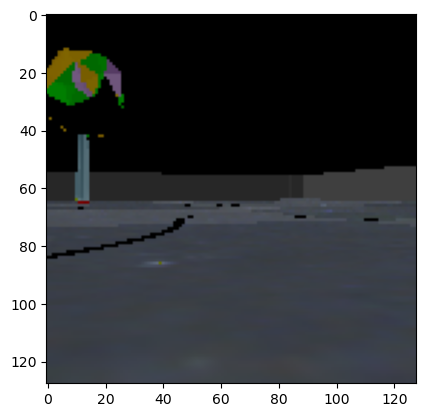

In [154]:
import matplotlib.pyplot as plt

plt.imshow(-epuck1.camera_image()[::-1, :, :])

You can now close this session properly by executing the cell below, and continue with the next session

In [156]:
close_session(simulator)